In [1]:
#Requirements:  1000 MKIDS on single readout line 
#               The bandwidth is 4-8 GHz
#               Smallest detectable wavelength is 402 nm
#               Q factor is constant on all frequencies
#               
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
#%matplotlib widget
import kidcalc as kc # KID model
import SC # properties of superconducting materials

In [2]:
#Design parameters
N_MKIDs = 1000
N_read = int(1e3)
df = 0.3e6
f0_B = 4.004e9 #Hz resonance frequency B
f0_A = f0_B - df   #Hz resonance frequency A
kbT0 = 86.17 * .1 #µeV, operating temperature of 100 mK
hw0_A = 6.582e-4*2*np.pi*f0_A*1e-6 #Energy inherent in KID at fres
hw0_B = 6.582e-4*2*np.pi*f0_B*1e-6 #Energy inherent in KID at fres
Qi_sat = 1e16
Qc = 5.0e4     #Coupling quality factor
W_ind = 4 #Inductor width in µm
L_ind = 626 #Inductor length in µm
d_ind = 40e-3 #Inductor film thickness is µm
# V_ind = W_ind *L_ind * d_ind
V_ind = 15 # µm^3 inductor volume

supercond = SC.bTa() # material constants
ak = .96 # Kinetic Inductance fraction
beta = 2    #Thin film beta approximation
lmbda = 402 #nm, gives the max. E for the responsivity curve
etapb = .55 #Pair breaking efficiency 


In [3]:
dNqp = etapb * 6.528e-4*2*np.pi* 3e8 / (lmbda * 1e-3) / supercond.D0
Nqp0 = V_ind * kc.nqp(kbT0, supercond.D0, supercond)
kbTeff = kc.kbTeff((Nqp0 + dNqp)/V_ind, supercond)

def KID_eq_properties(hW0, D0, f0):
    s10, s20 = kc.cinduct(hW0, D0, kbT0)
    Qi_Nqp0 = 2/(ak*beta) * s20/s10
    Qi0 = Qi_Nqp0 * Qi_sat / (Qi_Nqp0 + Qi_sat)  #Physical systems have limited Qi
    Q0 = Qc * Qi0/ (Qc + Qi0)
    Lk0 = np.imag(1/(s10-1j*s20))/(2*np.pi*f0)
    C = ak/(f0**2*Lk0) 
    Lg = Lk0*(1/ak-1)
    return s10, s20, Qi0, Q0, Lk0, Lg, C

# calculate equilibrium complex conductivity, Qi, Lk and from that C and Lg (for later fres calc)
s10_A, s20_A, Qi0_A, Q0_A, Lk0_A, Lg_A, C_A = KID_eq_properties(hw0_A, supercond.D0, f0_A)
s10_B, s20_B, Qi0_B, Q0_B, Lk0_B, Lg_B, C_B = KID_eq_properties(hw0_B, supercond.D0, f0_B)

def dB_scale(signal):
    dB_signal = 10*np.log10(np.abs(signal))
    return dB_signal

#Define frequency range of interest 
f_read_min = f0_B - 8*f0_B/Q0_B
f_read_max = f0_B + 4*f0_B/Q0_B
f_read = np.linspace(f_read_min, f_read_max, N_read)
f_dis = np.abs(f0_A-f0_B)

print(Qi0_A*Qc/(Qi0_A+Qc))
print(Qi0_B*Qc/(Qi0_B+Qc))
print()

49964.13862919989
49964.13881552118



In [4]:
#calculate complex conductivities and excess quasiparticles during pulse (between kbT0 and kbTeff)
kbTarr = np.logspace(np.log10(kbT0), np.log10(kbTeff), N_read)
s1_A, s2_A, exNqp = np.zeros((3, len(kbTarr)))
for i, kbT in enumerate(kbTarr):
    s1_A[i], s2_A[i] = kc.cinduct(hw0_A, supercond.D0, kbT)
    

s1_B, s2_B = np.zeros((2, len(kbTarr)))
for i, kbT in enumerate(kbTarr):
    s1_B[i], s2_B[i] = kc.cinduct(hw0_B, supercond.D0, kbT)
    exNqp[i] = V_ind * kc.nqp(kbT, supercond.D0, supercond)

x_center = 0.5003586118447881


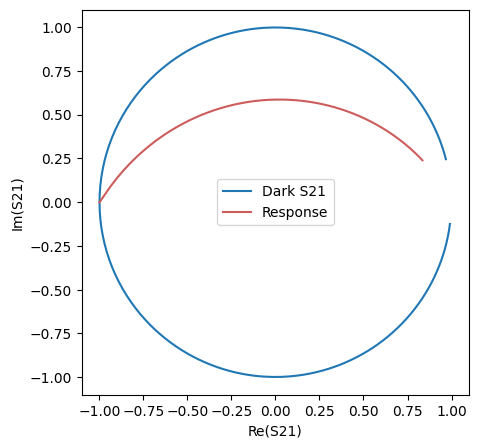

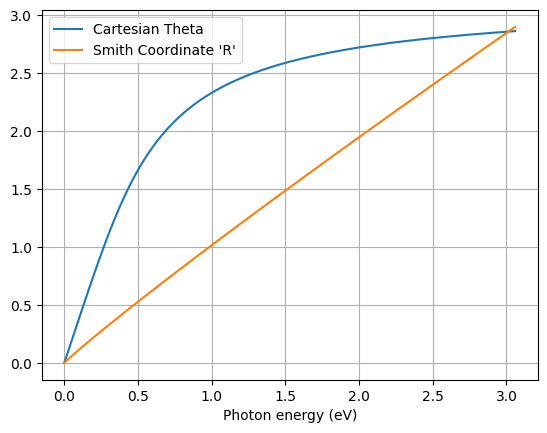

In [5]:
exlambda = etapb * 6.528e-4*2*np.pi* 3e8 / (exNqp) / supercond.D0 * 1e3
exE = (6.528e-16*2*np.pi)*(3e8/(exlambda*1e-9))
fwhm = f0_B / Q0_B

def KID_response(Qi0, Qc, f_read, f0, s1, s2, Lg, C):
    S21_0 = kc.S21(Qi0, Qc, f_read, f0)
    Lk = np.imag(1/(s1-1j*s2))/(2*np.pi*f0)
    f_resp = 1/np.sqrt(C*(Lk + Lg))
    Qi_Nqp = (2*s2)/(ak*beta*s1)
    Qi_resp = Qi_Nqp * Qi_sat / (Qi_Nqp + Qi_sat)
    Q_resp = Qc * Qi_resp / (Qc + Qi_resp)
    return S21_0, Lk, f_resp, Qi_resp, Q_resp

def calc_x_center(Q_dark, Qi_dark):
    S21_min = Q_dark/Qi_dark
    x_center = (1+S21_min)/2
    return x_center

S21_0_A, Lk_A, f_resp_A, Qi_resp_A, Q_resp_A = KID_response(Qi0_A, Qc, f_read, f0_A, s1_A, s2_A, Lg_A, C_A)
S21_0_B, Lk_B, f_resp_B, Qi_resp_B, Q_resp_B = KID_response(Qi0_B, Qc, f_read, f0_B, s1_B, s2_B, Lg_B, C_B)

S21_resp_B = kc.S21(Qi_resp_B, Qc, f_read, f_resp_B)
S21_prod = S21_0_A*S21_0_B


f0_index = np.argmin(S21_0_B)
x_center = calc_x_center(Q0_B,Qi0_B)
S21_resp = kc.S21(Qi_resp_B.reshape(-1,1), Qc, f_read, f_resp_B.reshape(-1,1))

theta = np.arctan2(S21_resp[:,f0_index].imag, (x_center- S21_resp[:,f0_index].real))
print("x_center =",x_center)

def smith_transform(S21, xc, f_idx):
    Gamma = (S21[:,f_idx].real-xc)/xc + 1j*S21[:,f_idx].imag/xc
    z = (1+Gamma)/(1-Gamma)
    Rsmith = np.real(z)
    Xsmith = np.imag(z)
    return Rsmith, Xsmith

Rsmith, Xsmith = smith_transform(S21_resp, x_center, f0_index)


plt.figure(figsize=(5, 5))
plt.plot((S21_0_B.real-x_center)/x_center, S21_0_B.imag/x_center, label = "Dark S21")
plt.plot((S21_resp[:,f0_index].real-x_center)/x_center, S21_resp[:,f0_index].imag/x_center, color = "indianred", label = "Response")
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.xlabel("Re(S21)")
plt.ylabel("Im(S21)")
plt.legend()

plt.figure()
plt.plot(exE, theta, label = "Cartesian Theta")
plt.plot(exE, Rsmith, label = "Smith Coordinate 'R'")
plt.xlabel("Photon energy (eV)")
plt.grid()
plt.legend()

3 Situations where the phase response of a single MKID is calculated in the presence of a close frequency neighbour:
- 2 indentical, dark KIDs, where one is shifted over the other
- 2 KIDs where the higher frequency one is excited 
- 2 KIDs where both are excited 

C:\Users\hesel\AppData\Local\Temp\ipykernel_10952\3628102690.py:46: RuntimeWarning: divide by zero encountered in divide
  plt.plot(exE, dB_scale((theta_1-theta)/theta), label = "primary excited", color = "indianred" )
C:\Users\hesel\AppData\Local\Temp\ipykernel_10952\3628102690.py:47: RuntimeWarning: divide by zero encountered in divide
  plt.plot(exE, dB_scale((theta_2-theta)/theta), label = "neigbour excited", color = "lime")
C:\Users\hesel\AppData\Local\Temp\ipykernel_10952\3628102690.py:48: RuntimeWarning: divide by zero encountered in divide
  plt.plot(exE, dB_scale((theta_3-theta)/theta), label = "both excited", color = "goldenrod", linestyle = '-.')
C:\Users\hesel\AppData\Local\Temp\ipykernel_10952\3628102690.py:55: RuntimeWarning: divide by zero encountered in divide
  plt.plot(exE, dB_scale((Xsmith_1-Xsmith)/Xsmith), label = "primary excited", color = "indianred" )
C:\Users\hesel\AppData\Local\Temp\ipykernel_10952\3628102690.py:56: RuntimeWarning: divide by zero encountered i

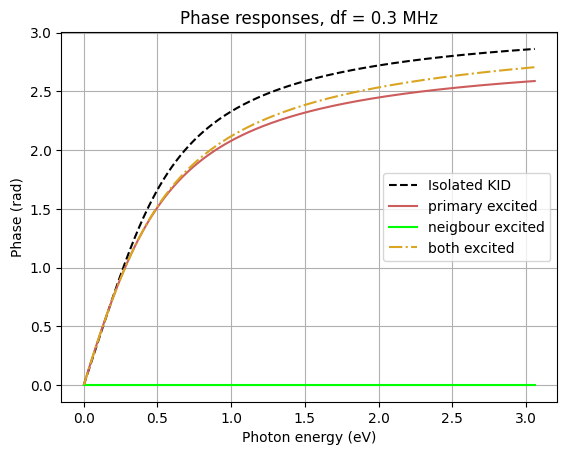

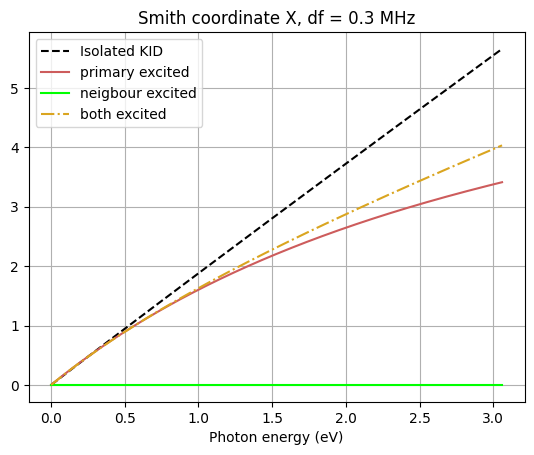

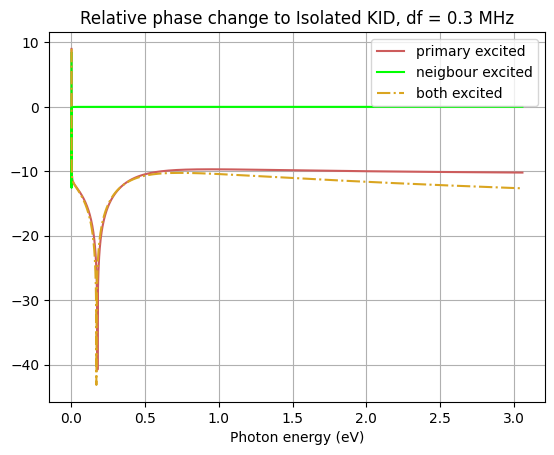

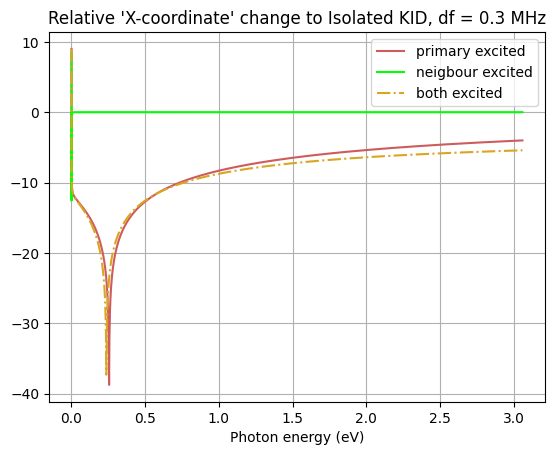

In [6]:
#Define 2 KIDs:
primary_resp = kc.S21(Qi_resp_B.reshape(-1,1), Qc, f_read, f_resp_B.reshape(-1,1))
neighbour_resp = kc.S21(Qi_resp_A.reshape(-1,1), Qc, f_read, f_resp_A.reshape(-1,1))

#2 KIDS, high frequency excited
combined_resp1 = primary_resp*neighbour_resp[0]
theta_1 = np.arctan2(combined_resp1[:,f0_index].imag, (x_center- combined_resp1[:,f0_index].real))
Rsmith_1,Xsmith_1 =smith_transform(combined_resp1, x_center, f0_index)

#2 KIDs, Neigbour excited
combined_resp2 = primary_resp[0]*neighbour_resp
theta_2 = np.arctan2(combined_resp2[:,f0_index].imag, (x_center- combined_resp2[:,f0_index].real))
Rsmith_2,Xsmith_2 =smith_transform(combined_resp2, x_center, f0_index)

#2 KIDs, both excited
combined_resp3 = primary_resp*neighbour_resp
theta_3 = np.arctan2(combined_resp3[:,f0_index].imag, (x_center- combined_resp3[:,f0_index].real))
Rsmith_3,Xsmith_3 = smith_transform(combined_resp3, x_center, f0_index)


plt.figure()
plt.title("Phase responses, df = 0.3 MHz")
plt.xlabel("Photon energy (eV)")
plt.ylabel("Phase (rad)")
plt.plot(exE, theta, label = 'Isolated KID', color = "black", linestyle = 'dashed')
plt.plot(exE, theta_1, label = "primary excited", color = "indianred")
plt.plot(exE, theta_2, label = "neigbour excited", color = "lime")
plt.plot(exE, theta_3, label = "both excited", color = "goldenrod", linestyle = '-.')
plt.legend()
plt.grid()

plt.figure()
plt.title("Smith coordinate X, df = 0.3 MHz")
plt.xlabel("Photon energy (eV)")
plt.plot(exE, Xsmith, label = 'Isolated KID', color = "black", linestyle = 'dashed')
plt.plot(exE, Xsmith_1,label = "primary excited", color = "indianred" )
plt.plot(exE, Xsmith_2, label = "neigbour excited", color = "lime")
plt.plot(exE, Xsmith_3, label = "both excited", color = "goldenrod", linestyle = '-.')
plt.legend()
plt.grid()

#Plotting change, relative to isolated KID in dB scale
plt.figure()
plt.title("Relative phase change to Isolated KID, df = 0.3 MHz")
plt.xlabel("Photon energy (eV)")
plt.plot(exE, dB_scale((theta_1-theta)/theta), label = "primary excited", color = "indianred" )
plt.plot(exE, dB_scale((theta_2-theta)/theta), label = "neigbour excited", color = "lime")
plt.plot(exE, dB_scale((theta_3-theta)/theta), label = "both excited", color = "goldenrod", linestyle = '-.')
plt.legend()
plt.grid()

plt.figure()
plt.title("Relative 'X-coordinate' change to Isolated KID, df = 0.3 MHz")
plt.xlabel("Photon energy (eV)")
plt.plot(exE, dB_scale((Xsmith_1-Xsmith)/Xsmith), label = "primary excited", color = "indianred" )
plt.plot(exE, dB_scale((Xsmith_2-Xsmith)/Xsmith), label = "neigbour excited", color = "lime")
plt.plot(exE, dB_scale((Xsmith_3-Xsmith)/Xsmith), label = "both excited", color = "goldenrod", linestyle = '-.')
plt.legend()
plt.grid()

In [12]:
def interact_phase():
    ## Set up the plot data
    fig   = plt.figure(figsize=(5,5))
    # plt.plot(f_read,10*np.log10(np.abs(S21_0*S21_1)), linewidth=1, label="Unloaded S21")
    plt.plot(exE, theta, label = 'Isolated KID', color = "black", linestyle = 'dashed')
    line1, = plt.plot([], [], linewidth=2, label="Primary excited", color = "indianred")# Initialize curve to empty data.
    line2, = plt.plot([], [], linewidth=2, label="Neighbour excited", color = "lime")
    line3, = plt.plot([], [], linewidth=2, label="Both Excited", color = "goldenrod", linestyle = "-.")
    ## Set up the figure axes, etc.
    plt.title("Cartesian phases")
    plt.xlabel('Photon energy (eV)')
    plt.ylim(-0.1, np.pi)
    plt.xlim(0, np.max(exE)+0.1)
    plt.ylabel('phase (rad)')
    plt.grid()
    plt.legend()
    plt.close()      # Don't show the figure yet.

    ## Callback function
    def plot_phase(df_slider):
        hW_neighbour = 6.582e-4*2*np.pi*(f0_B-df_slider)*1e-6
        Qi0_neighbour =  KID_eq_properties(hW_neighbour, supercond.D0, f0_B-df_slider)[2]
        S21_0_neighbour, Lk_neighbour, f_resp_neighbour, Qi_resp_neighbour, Q_resp_neighbour = KID_response(Qi0_neighbour, Qc, f_read, f0_B-df_slider, s1_A, s2_A, Lg_A, C_A)
        neighbour_resp = kc.S21(Qi_resp_neighbour.reshape(-1,1), Qc, f_read, f_resp_neighbour.reshape(-1,1))
        
        combined_resp1 = primary_resp*neighbour_resp[0]
        combined_resp2 = primary_resp[0]*neighbour_resp
        combined_resp3 = primary_resp*neighbour_resp

        theta_1 = np.arctan2(combined_resp1[:,f0_index].imag, (x_center- combined_resp1[:,f0_index].real))
        theta_2 = np.arctan2(combined_resp2[:,f0_index].imag, (x_center- combined_resp2[:,f0_index].real))
        theta_3 = np.arctan2(combined_resp3[:,f0_index].imag, (x_center- combined_resp3[:,f0_index].real))
        
        
        line1.set_data(exE,theta_1)
        line2.set_data(exE, theta_2)
        line3.set_data(exE, theta_3)
        display(fig)

    ## Generate the user interface.
    interact(plot_phase, 
             df_slider = FloatSlider(min = 0 , max = 5e6, step = 1e5, value = df, description = "f_shift"))

def interact_smith():
    ## Set up the plot data
    fig   = plt.figure(figsize=(5,5))
    # plt.plot(f_read,10*np.log10(np.abs(S21_0*S21_1)), linewidth=1, label="Unloaded S21")
    plt.plot(exE, Xsmith, label = 'Isolated KID', color = "black", linestyle = 'dashed')
    line1, = plt.plot([], [], linewidth=2, label="Primary excited", color = "indianred")# Initialize curve to empty data.
    line2, = plt.plot([], [], linewidth=2, label="Neighbour excited", color = "lime")
    line3, = plt.plot([], [], linewidth=2, label="Both Excited", color = "goldenrod", linestyle = "-.")
    ## Set up the figure axes, etc.
    plt.title("Smith coordinate X")
    plt.xlabel('Photon energy (eV)')
    plt.ylim(-0.1, np.max(Xsmith)+0.1)
    plt.xlim(0, np.max(exE)+0.1)
    plt.ylabel("")
    plt.grid()
    plt.legend()
    plt.close()      # Don't show the figure yet.

    ## Callback function
    def plot_phase(df_slider):
        hW_neighbour = 6.582e-4*2*np.pi*(f0_B-df_slider)*1e-6
        Qi0_neighbour =  KID_eq_properties(hW_neighbour, supercond.D0, f0_B-df_slider)[2]
        S21_0_neighbour, Lk_neighbour, f_resp_neighbour, Qi_resp_neighbour, Q_resp_neighbour = KID_response(Qi0_neighbour, Qc, f_read, f0_B-df_slider, s1_A, s2_A, Lg_A, C_A)
        neighbour_resp = kc.S21(Qi_resp_neighbour.reshape(-1,1), Qc, f_read, f_resp_neighbour.reshape(-1,1))
        
        combined_resp1 = primary_resp*neighbour_resp[0]
        combined_resp2 = primary_resp[0]*neighbour_resp
        combined_resp3 = primary_resp*neighbour_resp

        Rsmith_1,Xsmith_1 = smith_transform(combined_resp1, x_center, f0_index)
        Rsmith_2,Xsmith_2 = smith_transform(combined_resp2, x_center, f0_index)
        Rsmith_3,Xsmith_3 = smith_transform(combined_resp3, x_center, f0_index)
        
        line1.set_data(exE, Xsmith_1)
        line2.set_data(exE, Xsmith_2)
        line3.set_data(exE, Xsmith_3)
        display(fig)

    ## Generate the user interface.
    interact(plot_phase, 
             df_slider = FloatSlider(min = -5e6 , max = 5e6, step = 1e5, value = df, description = "f_shift"))

interact_phase()
interact_smith()


interactive(children=(FloatSlider(value=300000.0, description='f_shift', max=5000000.0, step=100000.0), Output…

interactive(children=(FloatSlider(value=300000.0, description='f_shift', max=5000000.0, min=-5000000.0, step=1…

Text(0, 0.5, 'Crosstalk')

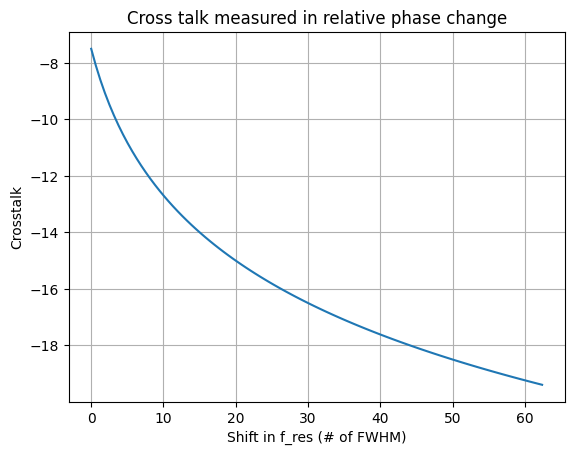

In [8]:
def calculate_phase_crosstalk(f0_A_arr):
    cross_array = np.zeros(len(f0_A_arr))
    
    for i in range(len(f0_A_arr)):
        hW_neighbour = 6.582e-4*2*np.pi*(f0_A_arr[i])*1e-6
        Qi0_neighbour =  KID_eq_properties(hW_neighbour, supercond.D0, f0_A_arr[i])[2]
        S21_0_neighbour, Lk_neighbour, f_resp_neighbour, Qi_resp_neighbour, Q_resp_neighbour = KID_response(Qi0_neighbour, Qc, f_read, f0_A_arr[i], s1_A, s2_A, Lg_A, C_A)
        neighbour_resp = kc.S21(Qi_resp_neighbour.reshape(-1,1), Qc, f_read, f_resp_neighbour.reshape(-1,1))
        
        combined_resp1 = primary_resp*neighbour_resp[0]
        combined_resp2 = primary_resp[0]*neighbour_resp
        combined_resp3 = primary_resp*neighbour_resp
        theta_1 = np.arctan2(combined_resp1[:,f0_index].imag, (x_center- combined_resp1[:,f0_index].real))

        cross_array[i] = dB_scale((theta_1[-1]-theta[-1])/theta[-1])
    return cross_array

df_array = np.linspace(f0_B-5e6, f0_B, 100)
phase_cross = calculate_phase_crosstalk(df_array)

plt.plot((f0_B-df_array)/fwhm, phase_cross)
plt.title("Cross talk measured in relative phase change")
plt.grid()
plt.xlabel("Shift in f_res (# of FWHM)")
plt.ylabel("Crosstalk")

In [ ]:
def interact_S21():
    ## Set up the plot data
    fig   = plt.figure(figsize=(8,3))
    plt.plot(f_read,10*np.log10(np.abs(S21_prod)), linewidth=1, label="Unloaded S21")
    line, = plt.plot([], [], linewidth=2, label="Loaded S21", color = "indianred")# Initialize curve to empty data.

    ## Set up the figure axes, etc.
    plt.title(r"Varying $T_{eff}$")
    plt.xlim(min(f_read), max(f_read))
    plt.ylim(-40, 0.1)
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('S21 (dB)')
    plt.legend()
    plt.close()      # Don't show the figure yet.

    ## Callback function
    def plot_S21(kbT_slider,f_dis_slider):
        s1_resp_B, s2_resp_B = kc.cinduct(hw0_B, supercond.D0, kbT_slider)
        Lk_resp_B = np.imag(1/(s1_resp_B-1j*s2_resp_B))/(2*np.pi*f0_B)
        f_resp_B = 1/np.sqrt(C_B*(Lk_resp_B + Lg_B))
        Qi_resp_B = (2*s2_resp_B)/(ak*beta*s1_resp_B)
        S21_resp_B = kc.S21(Qi_resp_B, Qc, f_read, f_resp_B)
        S21_A = kc.S21(Qi0_A, Qc, f_read, f0_A+f_dis_slider)
        line.set_data(f_read, dB_scale(S21_resp_B*S21_A))
        display(fig)
        

    ## Generate the user interface.
    interact(plot_S21, 
             kbT_slider=FloatSlider(min=min(kbTarr), max=1.1*max(kbTarr), step=0.1, value=kbT0, description = "kbT"),
             f_dis_slider = FloatSlider(min = 0 , max = 1.2*f_dis, step = 1e4, value = 0, description = "f_shift"))

interact_S21()


In [ ]:
def interact_circle():
    ## Set up the plot data
    fig   = plt.figure(figsize=(5,5))
    # plt.plot(f_read,10*np.log10(np.abs(S21_0*S21_1)), linewidth=1, label="Unloaded S21")
    line, = plt.plot([], [], linewidth=2, label="Loaded S21", color = "indianred")# Initialize curve to empty data.

    ## Set up the figure axes, etc.
    plt.title("Resonance circle")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('Re(S21)')
    plt.ylabel('Im(S21)')
    plt.legend()
    plt.close()      # Don't show the figure yet.

    ## Callback function
    def plot_circle(kbT_slider,f_dis_slider):
        s1_resp, s2_resp = kc.cinduct(hw0_B, supercond.D0, kbT_slider)
        Lk_resp = np.imag(1/(s1_resp-1j*s2_resp))/(2*np.pi*f0_B)
        f_resp = 1/np.sqrt(C_B*(Lk_resp + Lg_B))
        Qi_resp = (2*s2_resp)/(ak*beta*s1_resp)
        S21_resp = kc.S21(Qi_resp, Qc, f_read, f_resp)
        S21_1_var = kc.S21(Qi0_B, Qc, f_read, f0_A+f_dis_slider)
        S21_combined = S21_resp * S21_1_var
        line.set_data(np.real(S21_combined), np.imag(S21_combined))
        display(fig)

        

    ## Generate the user interface.
    interact(plot_circle, 
             kbT_slider=FloatSlider(min=min(kbTarr), max=1.1*max(kbTarr), step=0.1, value=kbT0, description = r"T_eff"),
             f_dis_slider = FloatSlider(min = 0 , max = f_dis*2, step = 1e4, value = f_dis, description = "f_shift"))


interact_circle();

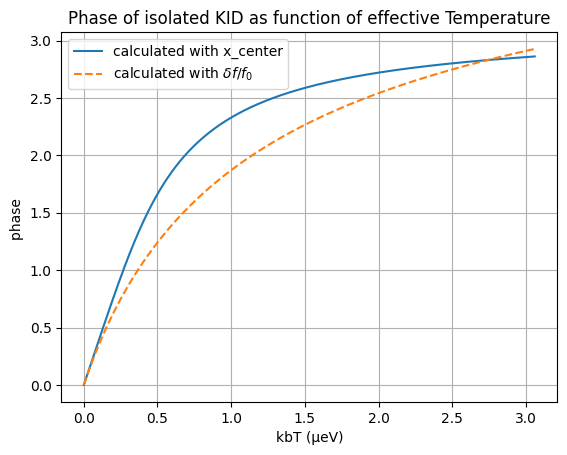

In [9]:

def phase_response_xc(s1_eff, s2_eff):
    S21_dark = kc.S21(Qi0_B, Qc, f_read, f0_B)
    f_res_index = np.argmin(dB_scale(S21_dark))
    phase_resp = np.zeros(len(s1_eff))
    theta = np.zeros(len(s1_eff))
    x_center = calc_x_center(Q_dark= Q0_B, Qi_dark=Qi0_B)
    # x_center = (1 + np.min(dB_scale(S21_dark))/2)
    Lk_resp = np.imag(1/(s1_eff-1j*s2_eff))/(2*np.pi*f0_B)
    f_resp = 1/np.sqrt(C_B*(Lk_resp + Lg_B))
    Qi_resp = (2*s2_eff)/(ak*beta*s1_eff)
    for i in range(len(s1_eff)):
        S21_resp = kc.S21(Qi_resp[i], Qc, f_read, f_resp[i])
        theta[i] = np.arctan2(S21_resp.imag[f_res_index], x_center - S21_resp.real[f_res_index])
        phase_resp[i] = (S21_resp.imag[f_res_index])/(x_center-S21_resp.real[f_res_index])
    return theta

def phase_response_df(s1_eff, s2_eff):
    S21_dark = kc.S21(Qi0_B, Qc, f_read, f0_B)
    f_res_index = np.argmin(dB_scale(S21_dark))
    Lk_resp = np.imag(1/(s1_eff-1j*s2_eff))/(2*np.pi*f0_B)
    f_resp = 1/np.sqrt(C_B*(Lk_resp + Lg_B))
    Qi_resp = (2*s2_eff)/(ak*beta*s1_eff)
    Q_resp = Qc * Qi_resp / (Qc + Qi_resp)
    phase_resp =  -4*Q_resp * (f_resp-f_read[f_res_index])/f_resp
    return phase_resp

# plt.plot(phase_response_xc(s1_B, s2_B)[1].real, phase_response_xc(s1_B, s2_B)[1].imag)

phase_xc = phase_response_xc(s1_B, s2_B)
phase_df = phase_response_df(s1_B, s2_B)

plt.plot(exE, phase_xc, label = 'calculated with x_center')
plt.plot(exE, phase_df, label = r"calculated with $\delta f/f_0$", linestyle = "dashed")
plt.title("Phase of isolated KID as function of effective Temperature")
plt.xlabel("kbT (µeV)")
plt.ylabel("phase ")
plt.legend()
plt.grid()

# print(kbTarr[np.argmin(phase_xc)])

In [ ]:
def cross_phase(S21_stat, f_shift):
    f_res_index = np.argmin(dB_scale(S21_stat))
    phase_dark = np.imag(S21_stat)[f_res_index]
    cross_theta = np.zeros(len(f_shift))
    theta = np.zeros(len(f_shift))
    
    for i in range(len(f_shift)):
        S21_shift = kc.S21(Qi0_A, Qc, f_read, f0_A+f_shift[i])
        S21_combined = S21_shift*S21_stat
        x_center = calc_x_center(Q_dark= Q0_B, Qi_dark= Qi0_B)
        cross_theta[i] = np.arctan2(S21_combined.imag[f_res_index], x_center - S21_combined.real[f_res_index])
        
    return cross_theta

fshift = np.linspace(0,0.5e6,N_read)

theta_shift = cross_phase(S21_0_B, fshift)

plt.plot((fshift-(f0_B-f0_A))/1e6, theta_shift)
plt.title("Phase at f0 of a dark static KID as another is shifted over it")
plt.xlabel("Difference in resonance frequencies (MHz)")
plt.ylabel("Phase response (rad)")
plt.grid()
print(theta_shift[10]) 



In [ ]:
#Calculate phase response for single position
def phase_response_cross(s1_eff, s2_eff, f_shift):
    S21_dark = kc.S21(Qi0_B, Qc, f_read, f0_B)
    S21_shift = kc.S21(Qi0_A, Qc, f_read, f0_B+f_shift)
    f_res_index = np.argmin(dB_scale(S21_dark))
    phase_resp = np.zeros(len(s1_eff))
    theta = np.zeros(len(s1_eff))
    Lk_resp = np.imag(1/(s1_eff-1j*s2_eff))/(2*np.pi*f0_B)
    f_resp = 1/np.sqrt(C_B*(Lk_resp + Lg_B))
    Qi_resp = (2*s2_eff)/(ak*beta*s1_eff)
    for i in range(len(s1_eff)):
        S21_resp = kc.S21(Qi_resp[i], Qc, f_read, f_resp[i])
        S21_combined = S21_shift*S21_resp
        x_center = calc_x_center(S21_combined)
        theta[i] = np.arctan2(S21_combined.imag[f_res_index], x_center - S21_combined.real[f_res_index])
    return theta

def interact_primary_response():
     ## Set up the plot data
    fig   = plt.figure(figsize=(5,5))
    plt.plot(kbTarr,phase_xc, linestyle= 'dashed', label = "Isolated KID")
    plt.grid()
    line, = plt.plot([], [], linewidth=2, label="KID with neighbour at f_shift", color = "indianred")# Initialize curve to empty data.
        ## Set up the figure axes, etc.
    plt.title("Higher frequency exited KID")
    plt.xlabel('kbTeff (u eV)')
    plt.ylabel('Phase (rad)')
    plt.legend()
    plt.close()      # Don't show the figure yet.
    def plot_phase(f_shift_slider):
    
        S21_dark = kc.S21(Qi0_B, Qc, f_read, f0_B)
        S21_shift = kc.S21(Qi0_A, Qc, f_read, f0_B+f_shift_slider)
        f_res_index = np.argmin(dB_scale(S21_dark))
        theta = np.zeros(len(s1_B))
        Lk_resp = np.imag(1/(s1_B-1j*s2_B))/(2*np.pi*f0_B)
        f_resp = 1/np.sqrt(C_B*(Lk_resp + Lg_B))
        Qi_resp = (2*s2_B)/(ak*beta*s1_B)
        for i in range(len(s1_B)):
            S21_resp = kc.S21(Qi_resp[i], Qc, f_read, f_resp[i])
            S21_combined = S21_shift*S21_resp
            x_center = calc_x_center(S21_combined)
            theta[i] = np.arctan2(S21_combined.imag[f_res_index], x_center - S21_combined.real[f_res_index])
        line.set_data(kbTarr, theta)
        display(fig)

    ## Generate the user interface.
    interact(plot_phase, 
             f_shift_slider = FloatSlider(min =-5e5 , max = 5e5, step = 1e4, value = 0, description = "f_shift"))


interact_primary_response()
interact_S21()
interact_circle()

In [ ]:
#Low frequency KID excited, high prequency KID still measured
def interact_secondary_response():
    
     ## Set up the plot data
    fig   = plt.figure(figsize=(5,5))
    plt.plot(kbTarr,phase_xc, linestyle= 'dashed', label = "Isolated KID")
    plt.grid()
    line, = plt.plot([], [], linewidth=2, label="KID with neighbour at f_shift", color = "indianred")# Initialize curve to empty data.
        ## Set up the figure axes, etc.
    plt.title("Lower frequency exited KID")
    plt.xlabel('kbTeff (u eV)')
    plt.ylabel('Phase (rad)')
    plt.legend()
    plt.close()      # Don't show the figure yet.
    def plot_phase(f_shift_slider):
        
        S21_dark = kc.S21(Qi0_B, Qc, f_read, f0_B)
        S21_shift = kc.S21(Qi0_A, Qc, f_read, f0_B+f_shift_slider)
        f_res_index = np.argmin(dB_scale(S21_shift))
        theta = np.zeros(len(s1_B))
        Lk_resp = np.imag(1/(s1_B-1j*s2_B))/(2*np.pi*(f0_B+f_shift_slider))
        f_resp = 1/np.sqrt(C_B*(Lk_resp + Lg_B))
        Qi_resp = (2*s2_B)/(ak*beta*s1_B)
        for i in range(len(s1_B)):
            S21_resp = kc.S21(Qi_resp[i], Qc, f_read, f_resp[i])
            S21_combined = S21_resp*S21_dark
            x_center = calc_x_center(S21_combined)
            theta[i] = np.arctan2(S21_combined.imag[f_res_index], x_center - S21_combined.real[f_res_index])
        line.set_data(kbTarr, theta)
        display(fig)

    ## Generate the user interface.
    interact(plot_phase, 
             f_shift_slider = FloatSlider(min =-1e5 , max = 1e5, step = 1e4, value = 0, description = "f_shift"))


interact_secondary_response()



In [ ]:
for count, val in enumerate(S21_resp_B):
    if np.abs(val) == min(np.abs(S21_resp_B)):
        print(f_read[count])
        print("Highest shift:",(f0_B - f_read[count])/1e6, "MHz")


S21_resp_B_min = min(Q_resp_B)/min(Qi_resp_B)
print(10*np.log10(np.abs(S21_resp_B_min)))

In [ ]:
#Calculating magnitude of frequency collisions in dB
S21_0min_B =10*np.log10(np.abs(Q0_B/Qi0_B))  

def calc_collision(s1, s2):

   #Find the index of the resonance frequency where crosstalk is measured
   index_f0_A = np.argmin(np.abs(np.array(f_read)-f0_A))
   crosstalk_array = np.zeros(N_read)

   #Calculate response at resonance of stationary KID
   for i in range(N_read):
      Lk_resp_B_i = np.imag(1/(s1[i]-1j*s2[i]))/(2*np.pi*f0_B)
      f_resp_B_i = 1/np.sqrt(C_B*(Lk_resp_B_i + Lg_B))
      Qi_resp_i = (2*s2[i])/(ak*beta*s1[i]) 
      S21_resp_i = 10*np.log10(np.abs(kc.S21(Qi_resp_i, Qc, f_read, f_resp_B_i)))
      crosstalk_array[i] = S21_resp_i[index_f0_A]

   return crosstalk_array


coll = calc_collision(s1_B, s2_B)


plt.plot(kbTarr, coll, label = "Frequency collision magnitude")
plt.title("Frequency collisions between 2 KIDs 0.3 MHz apart")
plt.ylabel("Magnitude (dB)")
plt.xlabel("Effective temperature (kbT)")
plt.vlines(16.336, -1.1, 0, linestyles= "dashed", color = "black", label= "kbT at 402nm")
plt.legend()

C:\Users\hesel\AppData\Local\Temp\ipykernel_10952\3562445351.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  collision_array[i] = S21_shift[f0_index]-  S21_stat[f0_index]


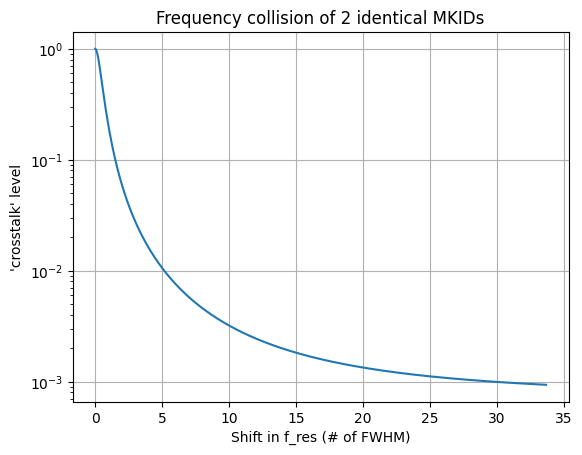

In [10]:
FWHM = f0_B/Q0_B

def Jochem_calc_collision(f_shift, S21_stat):
    f0_index = np.argmin(dB_scale(S21_stat))
    collision_array = np.zeros(len(f_shift))

    for i in range(len(f_shift)):
        S21_shift = kc.S21(Qi0_A, Qc, f_read, f0_A+f_shift[i])
        collision_array[i] = S21_shift[f0_index]-  S21_stat[f0_index]
 
    return collision_array

f_shift = np.linspace(0.3e6,3e6, N_read)
    
coll = Jochem_calc_collision(f_shift, S21_0_B)
    
plt.plot((f_shift-min(f_shift))/FWHM, 1-coll)
plt.xlabel("Shift in f_res (# of FWHM)")
plt.ylabel("'crosstalk' level")
plt.title("Frequency collision of 2 identical MKIDs")
plt.yscale("log")
plt.grid()